# Анализ развлекательного приложения

## Описание данных

**Цель анализа:**

Разобраться в причинах убытков развлекательного приложения с точки зрения вложений в рекламу.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:

   - лог сервера с данными об их посещениях,
   - выгрузка их покупок за этот период,
   - рекламные расходы.
       
Изучим откуда приходят пользователи и какими устройствами они пользуются, сколько стоит привлечение пользователей из различных рекламных каналов; сколько денег приносит каждый клиент, когда расходы на привлечение клиента окупаются, какие факторы мешают привлечению клиентов.

**Описание данных**

Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

   - User Id — уникальный идентификатор пользователя
   - Device — категория устройства пользователя
   - Session start — дата и время начала сессии
   - Session End — дата и время окончания сессии
   - Channel — идентификатор рекламного источника, из которого пришел пользователь
   - Region - страна пользователя

Таблица orders_log_short (информация о заказах):

   - User Id — уникальный id пользователя, который сделал заказ
   - Event Dt — дата и время покупки
   - Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

   - Channe — идентификатор рекламного источника
   - Dt — дата
   - Costs — затраты на этот рекламный источник в этот день
    
**Примечание:** на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели (14 дней) после привлечения. 

Органические пользователи из расчета окупаемости исключены

## Предобработка данных

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
visits, orders, costs = (
    pd.read_csv('visits_info_short.csv'),  # журнал сессий
    pd.read_csv('orders_info_short.csv'),  # покупки
    pd.read_csv('costs_info_short.csv'),  # траты на рекламу
)

In [3]:
# приведем названия столбцов к snake_case
for i in visits, orders, costs:
    i.columns = i.columns.str.lower().str.replace(' ', '_')

In [4]:
print(visits['session_start'].dtype,
      visits['session_end'].dtype,
      orders['event_dt'].dtype,
      costs['dt'].dtype)

object object object object


In [5]:
# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

print(visits['session_start'].dtype,
      visits['session_end'].dtype,
      orders['event_dt'].dtype,
      costs['dt'].dtype)

datetime64[ns] datetime64[ns] datetime64[ns] object


In [6]:
def first_look(df):
    print('...........Первые 5 строк...........')
    display(df.head())
    print('')
    print('')
    print('...........Тип данных...........')
    print('')
    df.info()
    print('')
    print('')
    print('.'*10,'Пропуски','.'*10)
    print('')
    count = 0
    for column in df.columns:
        if df[column].isna().sum()>0:
            print(column,'-',df[column].isna().sum(), 'пропусков')
            print(f'Доля пропусков в таблице составляет {(df[column].isna().sum())/len(df[column]):.1%}')
            count =+ 1
    if count == 0:
        print('Пропусков нет')
    print('')
    print('')
    print('...........Дубликаты...........')
    if df.duplicated().sum()>0:
        print('Дубликатов:', df.duplicated().sum())
    else:
        print('Дубликатов нет')

In [7]:
first_look(visits)

...........Первые 5 строк...........


,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40




...........Тип данных...........

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


.......... Пропуски ..........

Пропусков нет


...........Дубликаты...........
Дубликатов нет


In [8]:
first_look(orders)

...........Первые 5 строк...........


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99




...........Тип данных...........

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


.......... Пропуски ..........

Пропусков нет


...........Дубликаты...........
Дубликатов нет


In [9]:
first_look(costs)

...........Первые 5 строк...........


,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1




...........Тип данных...........

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


.......... Пропуски ..........

Пропусков нет


...........Дубликаты...........
Дубликатов нет


## Функции для расчета и анализа LTV, ROI, удержания и конверсии


In [10]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [11]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [12]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [13]:
# функция для расчёта LTV и ROI
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [14]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [15]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(17, 12))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [16]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [17]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(22, 12))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

Получим профили пользователей. Для этого вызовем функцию get_profiles(), передав ей данные о посещениях, покупках и тратах на рекламу приложения

In [18]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


 Определим минимальную и максимальную даты привлечения пользователей

In [19]:
min_date = profiles['dt'].min()
max_date = profiles['dt'].max()
print(min_date, max_date)

2019-05-01 2019-10-27


У нас на руках данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года

Выясним, из каких **стран** пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. 
Найдём количество пользователей и долю платящих из каждой страны.

In [20]:
region_df = (
    profiles
    .pivot_table(index='region', values=['user_id','payer'],aggfunc= {'user_id':'count','payer':'sum'})
    .sort_values('user_id')
)

In [21]:
region_df['ratio, %'] = region_df['payer']/region_df['user_id']*100

In [22]:
region_df.sort_values('ratio, %',ascending=False).reset_index()

,region,payer,user_id,"ratio, %"
0,United States,6902,100002,6.901862
1,Germany,616,14981,4.111875
2,UK,700,17575,3.982930
3,France,663,17450,3.799427


**Вывод**:

    В США доля платящих пользователей почти 7%, также США обгоняет остальные страны по количесту привлеченных пользователей. 
    А вот во Франции из 17.5 тысяч пользователей только 3.8% совершили покупку.

Выясним какими **устройствами** пользуются клиенты и какие устройства предпочитают платящие пользователи. Найдём количество пользователей и долю платящих для каждого устройства.

In [23]:
device_df = (
    profiles
    .pivot_table(index='device', values=['user_id','payer'],aggfunc= {'user_id':'count','payer':'sum'})
    .sort_values('user_id')
)

In [24]:
device_df['ratio, %'] = device_df['payer']/device_df['user_id']*100
device_df.sort_values('ratio, %', ascending=False).reset_index()

,device,payer,user_id,"ratio, %"
0,Mac,1912,30042,6.364423
1,iPhone,3382,54479,6.207897
2,Android,2050,35032,5.851793
3,PC,1537,30455,5.046790


**Вывод**:

    Почти 9% пользователи ноутбуков Mac делают заказ в приложении. Что касается PC,то лишь доля платящих пользоватей составляет лишь 6.8% 

Определим **каналы**, из которых пришло больше всего платящих пользователей. Найдём количество пользователей и долю платящих для каждого канала привлечения.

In [25]:
channel_df = (
    profiles
    .pivot_table(index='channel', values=['user_id','payer'],aggfunc= {'user_id':'count','payer':'sum'})
    .sort_values('user_id')
)

In [26]:
channel_df['ratio, %'] = channel_df['payer']/channel_df['user_id']*100
channel_df.sort_values('ratio, %', ascending=False).reset_index()

,channel,payer,user_id,"ratio, %"
0,FaceBoom,3557,29144,12.204914
1,AdNonSense,440,3880,11.340206
2,lambdaMediaAds,225,2149,10.469986
3,TipTop,1878,19561,9.600736
4,RocketSuperAds,352,4448,7.913669
5,WahooNetBanner,453,8553,5.296387
6,YRabbit,165,4312,3.826531
7,MediaTornado,156,4364,3.574702
8,LeapBob,262,8553,3.063253
9,OppleCreativeMedia,233,8605,2.707728


**Вывод**:

    12.2% пользователей, пришедших из FaceBoom совершили покупку, На втором месте с 11.3% - AdNonSense и lambdaMediaAds с 10.5% на третьем. Меньше всего покупающих среди тех, кто пришел на платформу без рекламы, 2.1%

## Маркетинг

4.1. Посчитаем общую сумму расходов на маркетинг

In [27]:
# Посчитаем общую сумму расходов на маркетинг
costs_sum = costs['costs'].sum()
display(costs_sum)

105497.30000000002

Распределение трат по источникам

In [28]:
costs.pivot_table(
    index='channel',
    values='costs',
    aggfunc='sum').sort_values('costs', ascending=False).reset_index()

,channel,costs
0,TipTop,54751.30
1,FaceBoom,32445.60
2,WahooNetBanner,5151.00
3,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
6,LeapBob,1797.60
7,lambdaMediaAds,1557.60
8,MediaTornado,954.48
9,YRabbit,944.22


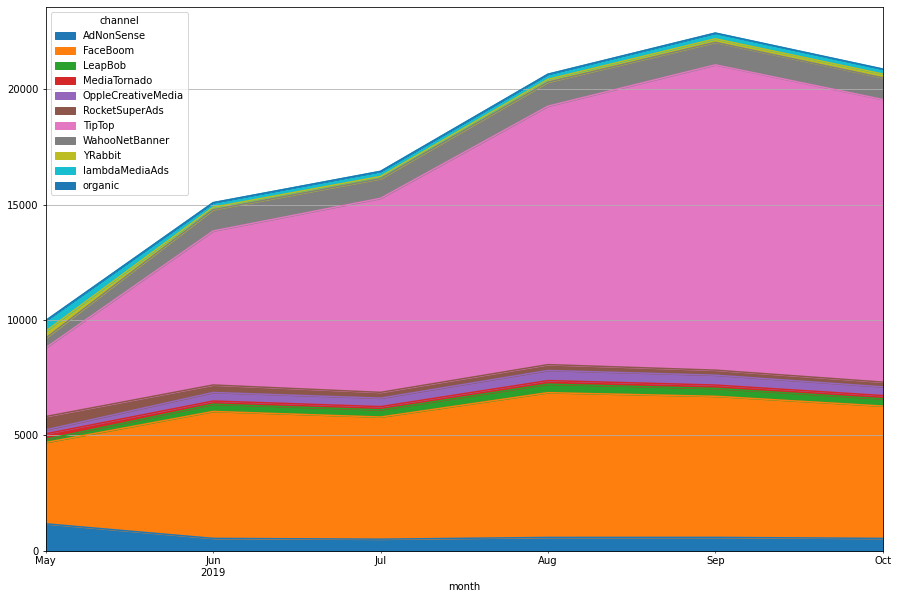

In [29]:
#изменение маркетинговых трат во времени по платформам
ax=profiles.pivot_table(
    index='month',  # даты первых посещений
    columns='channel',
    values='acquisition_cost',   
    aggfunc='sum'  
).plot.area(figsize=(15, 10), grid=True)

**Вывод**:

    Затраты на такие каналы как lambdaMediaAds,YRabbit,WahooNetBanner и TipTop постепенно увеличивались и в сентябре дотигли пика.
    Больше всего вкладываются в рекламу в TipTop
    Затраты на рекламу в Faceboom стабильно высокие, но не прирастают
    Маркетинговые затраты в AdNonSense Уменьшились с мая по Июнь

Рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика

In [30]:
# считаем средний CAC по каналам привлечения

cac = (
     profiles.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
    .sort_values('cac',ascending=False)
)
cac

,cac
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


**Вывод**

      В TipTop самый большой средний расход на привлечение пользователя, 2.8, 
      В FaceBoom 1 пользоваель обходится в 1.1, а в AdNonSense 1.0
      YRabbit, MediaTornado и LeapBob находятся на уровне 0.2
      organic траффик бесплатен и это здорово!

## Окупаемость рекламы для привлечения пользователей

### Общая окупаемость рекламы

Установим момент и горизонт анализа данных. 


На календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели (14 дней) после привлечения.

Оценим общую ситуацию — посмотрим на окупаемость рекламы. Рассчитаем и визуализируем LTV и ROI, вызвав функции get_ltv() и plot_ltv_roi()

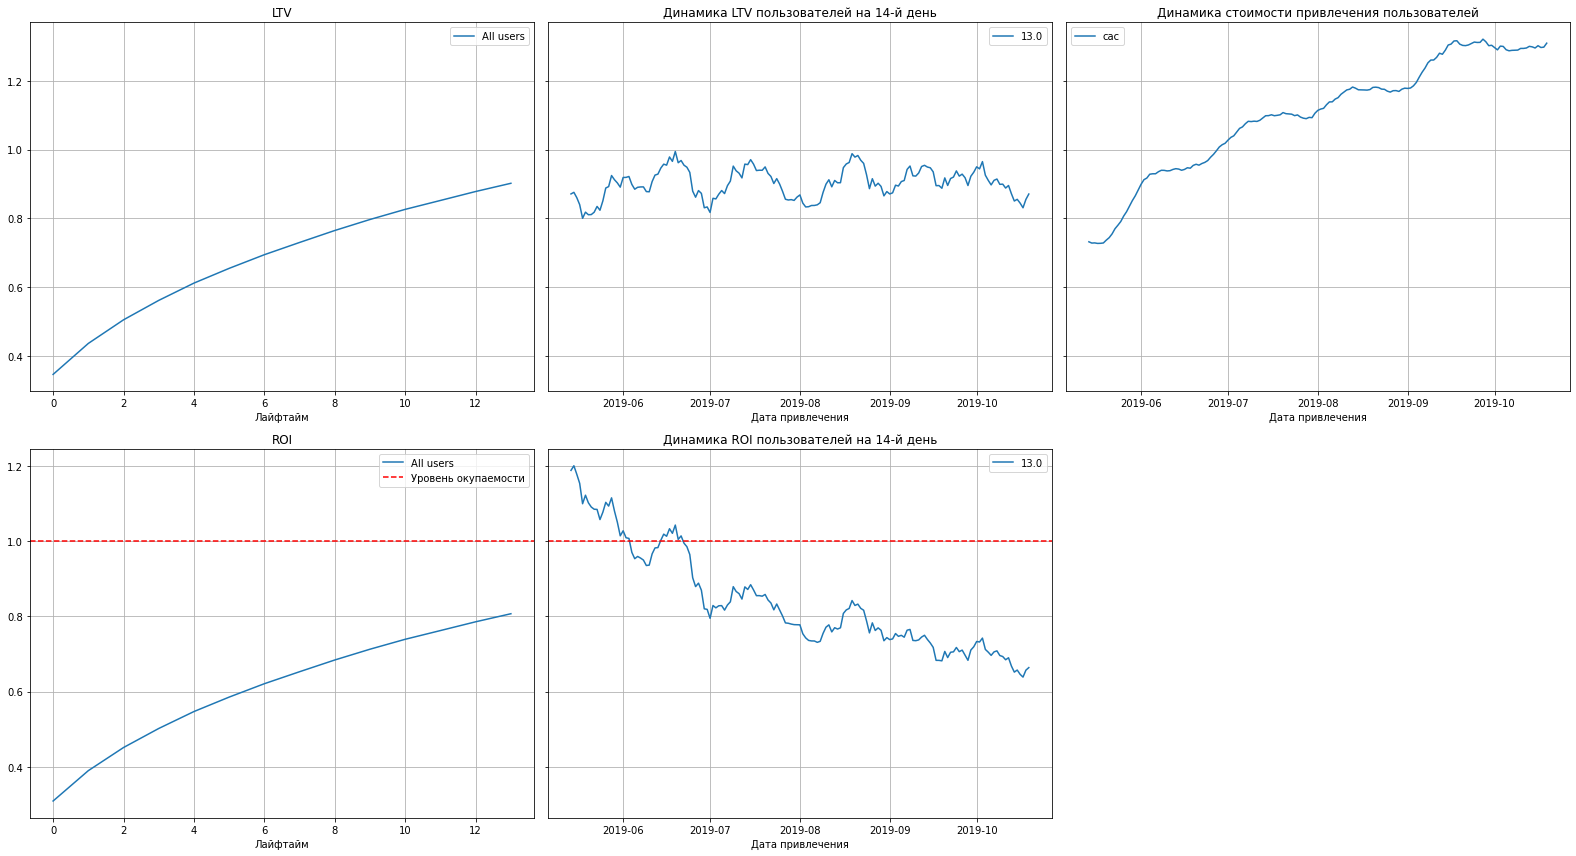

In [31]:
# получите сырые данные, таблицы LTV и ROI, а также таблицы динамики LTV и ROI
observation_date = datetime(2019, 11, 1).date() # момент анализа
horizon_days = 14 # горизонт анализа 
profiles = profiles[profiles['channel'] != "organic"]
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

По графикам можно сделать такие выводы:

    - Реклама не окупается. ROI в конце второй недели — чуть выше 80%.
    - CAC растёт. Значит, рекламный бюджет увеличивается.
    - LTV достаточно стабилен. Значит, дело не в ухудшении качества пользователей

### Окупаемость рекламы с разбивкой по устройствам

Передадим параметру dimensions столбец device

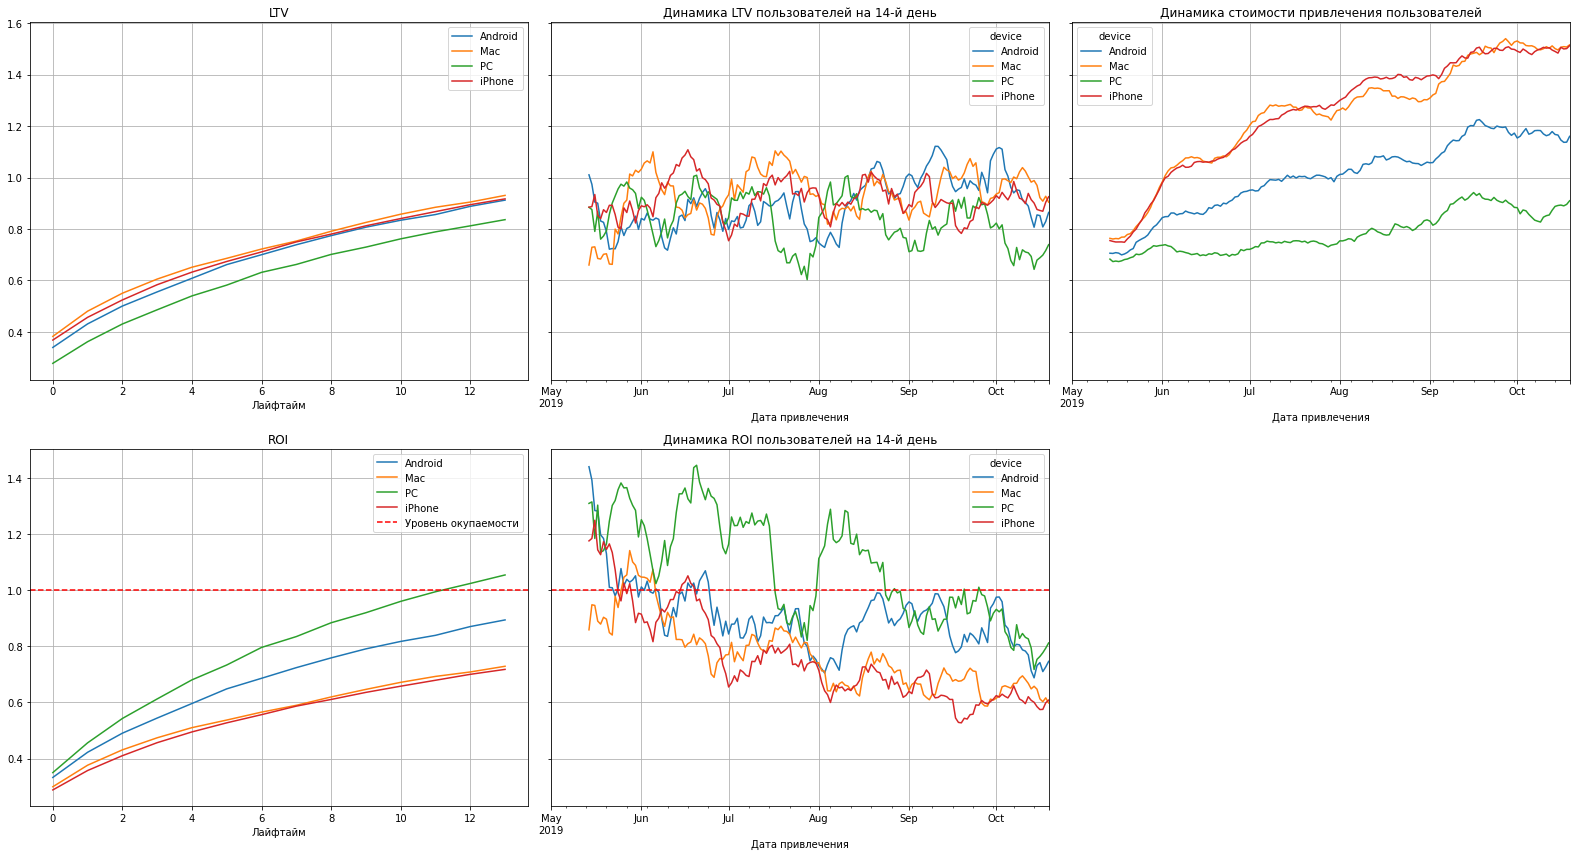

In [32]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

**Вывод**:

    - График динамики ROI показывает, что пользователи на PC, Android стабильно окупались на 120–140% уже в день привлечения, а пользоватям Mac не хватало до окупаемости примерно 20%.
    - Окупаемость пользователей PC снижается с сентября
    - Пользователь Iphone и Mac не приносит прибыль с июля не смотря на увеличение маркетингого бюджета

### Окупаемость рекламы с разбивкой по странам

Теперь проверим страну. Возможно, на окупаемость влияет неудачная реклама в конкретной стране

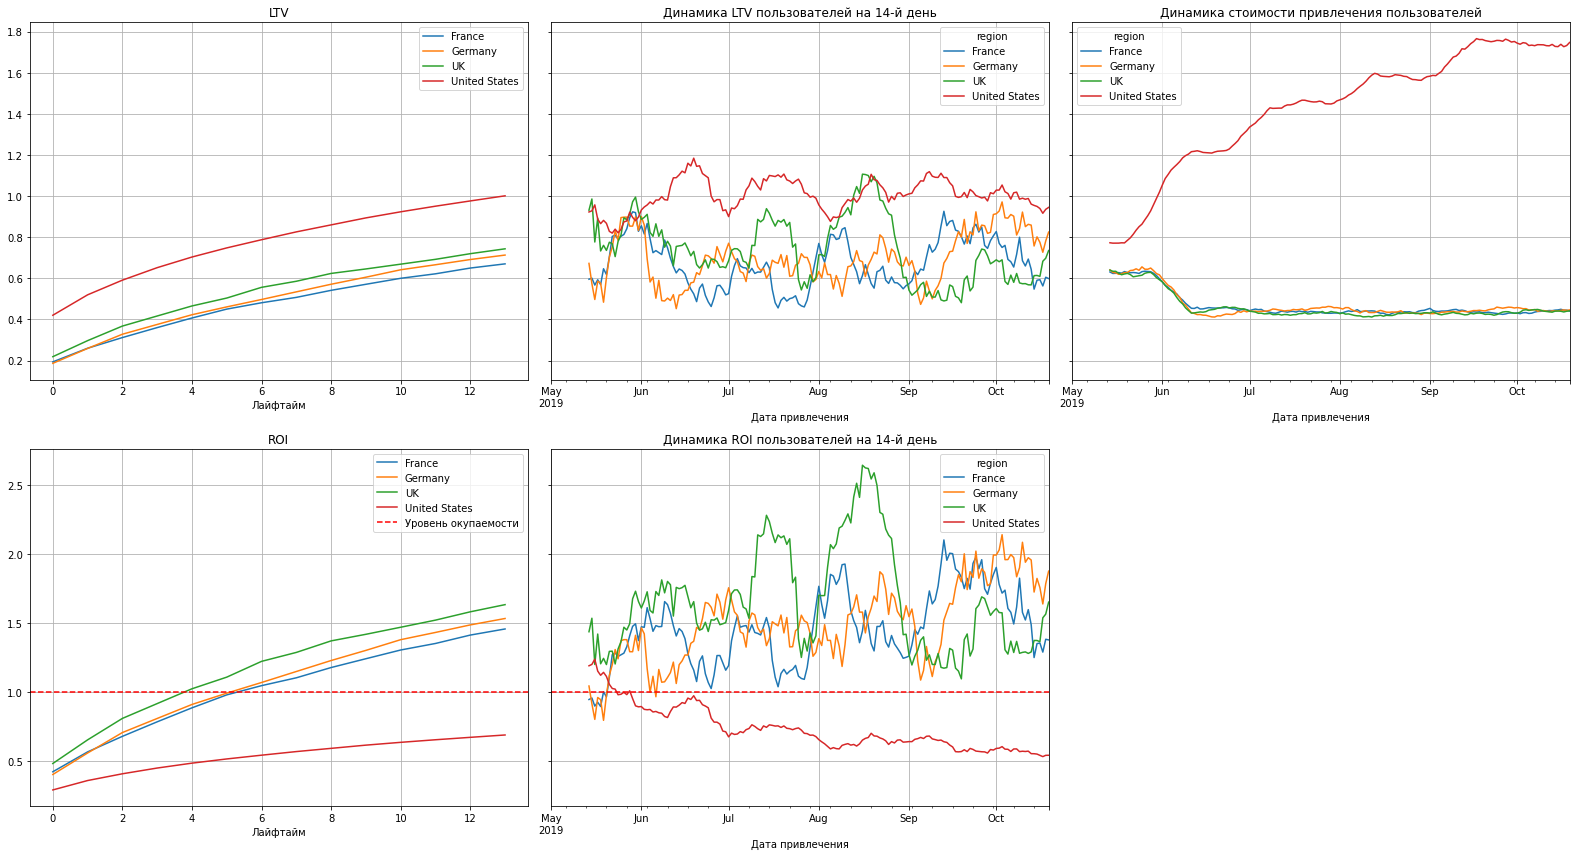

In [33]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

**Вывод**:

    Реклама окупается везде кроме USA.
    Стоимость привлечения стабильна и одинакова для всех стран, кроме USA, где она растёт
    LTV стабилен.
    Лучше всего окупается UK

### Окупаемость рекламы с разбивкой по рекламным каналам

Перейдём к каналам рекламы

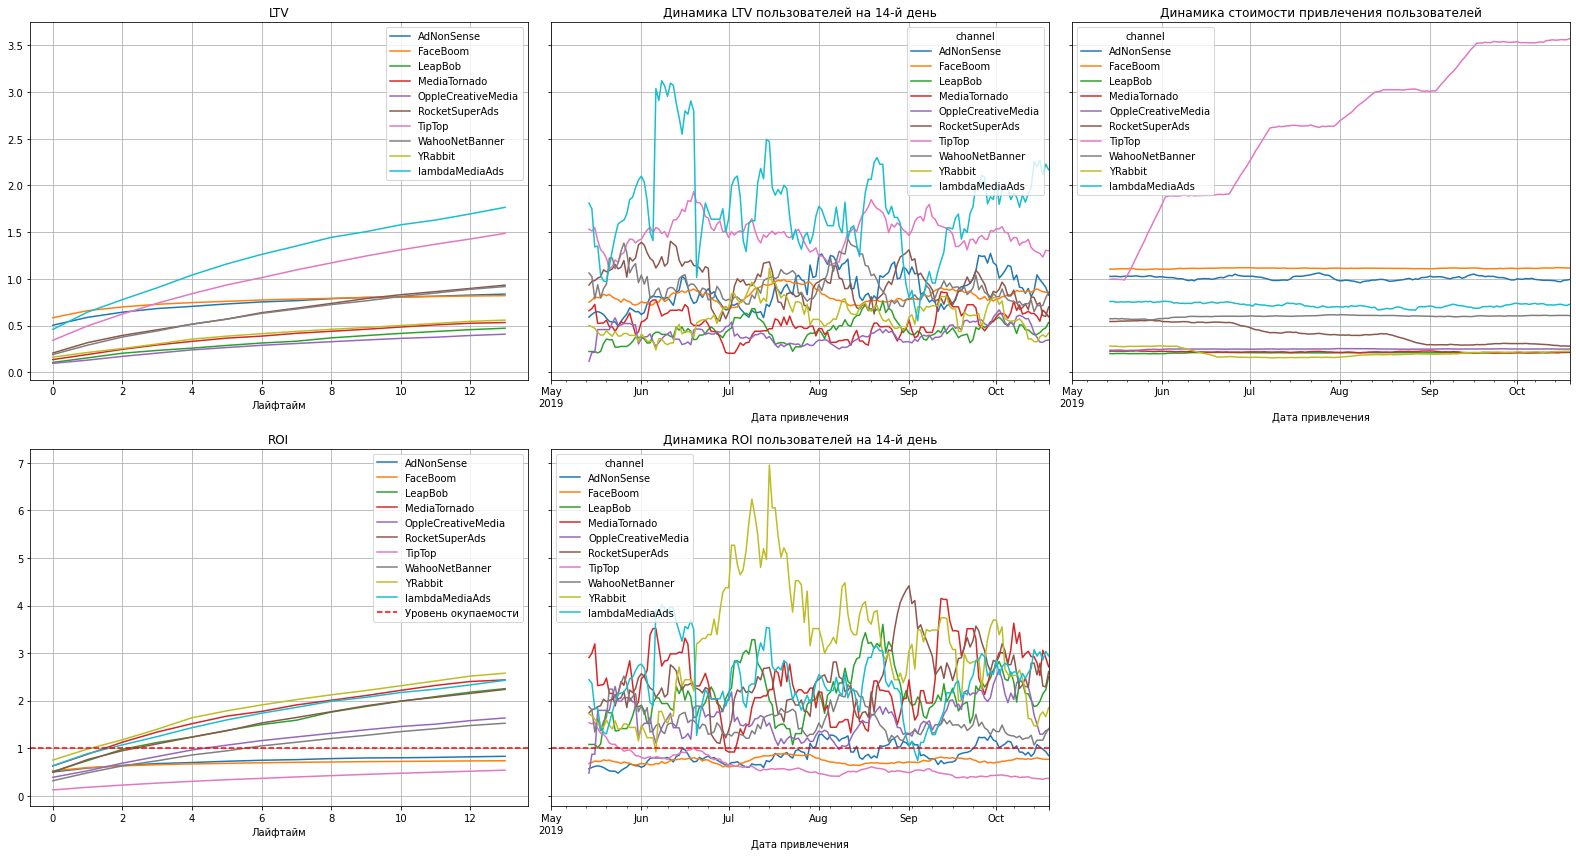

In [34]:
# смотрим окупаемость с разбивкой по каналам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

**Вывод**

      Стабильные качество  во всех каналах. 
      CAC стабилен по всем каналам кроме TipTop - там он растет регулярно с начала года 
      Каналы FaceBoom и TipTop убыточны, а вот YRabbit показывает окупаемость 700% в Июле-Августе

### Графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.

Узнаем, в чём причина: в низкой конверсии или низком удержании.
Посчитаем и визуализируем конверсию, вызвав функции get_conversion() и plot_conversion()

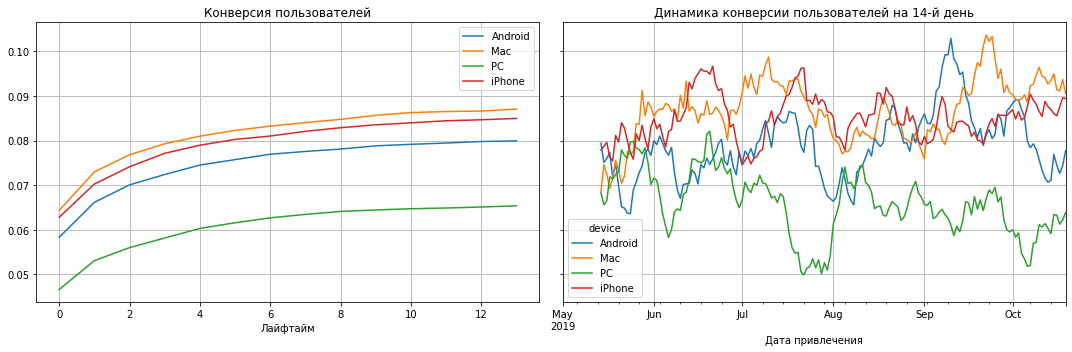

In [35]:
dimensions = ['device']
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

**Вывод**: Судя по графикам, пользователи  iPhone и Mac конвертируются очень хорошо, причём постоянно. Видимо, дело в удержании. У пользователей PC самаая низкая конверсия. Вызовем функции get_retention() и plot_retention(), чтобы рассчитать и отразить на графиках этот показатель.

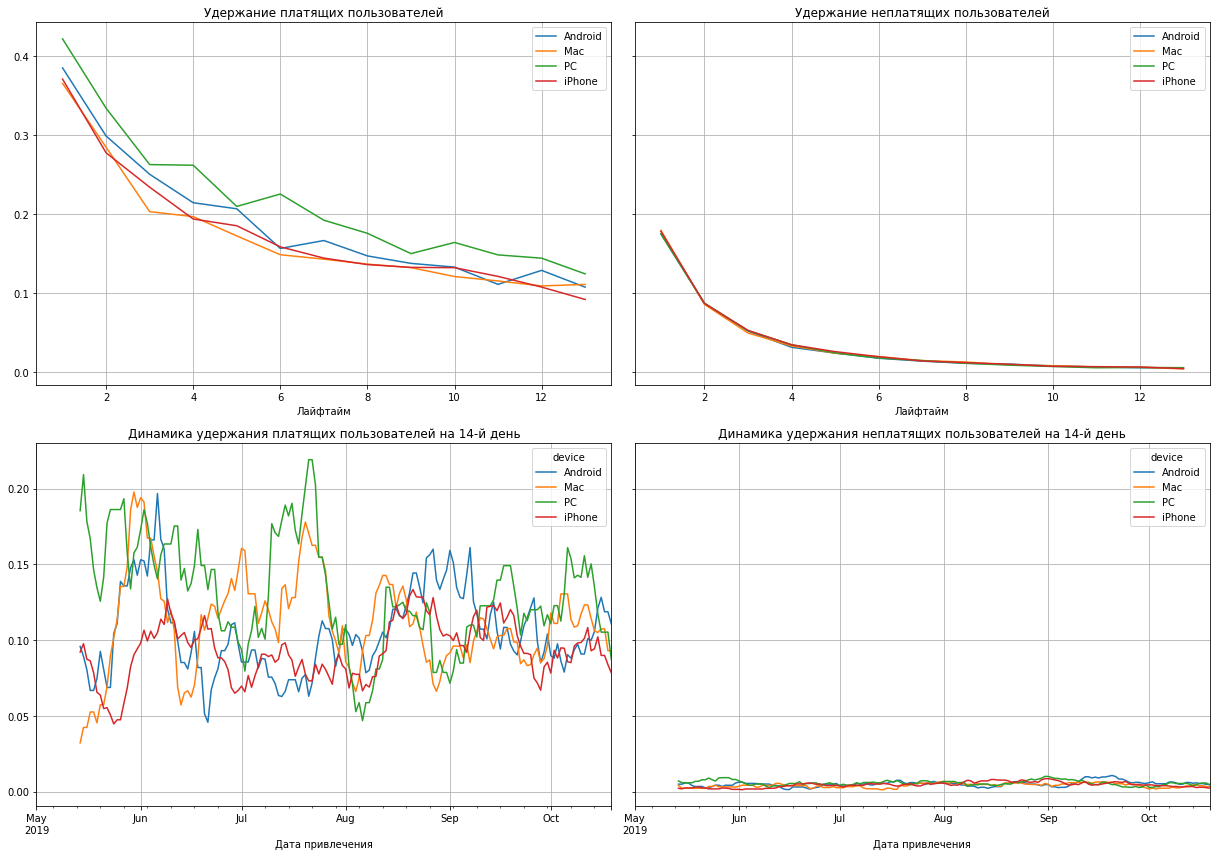

In [36]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Вывод**: Удержания платящих пользователей плохие у всех девайсов. Значит, дело не в устройствах и технических проблем нет

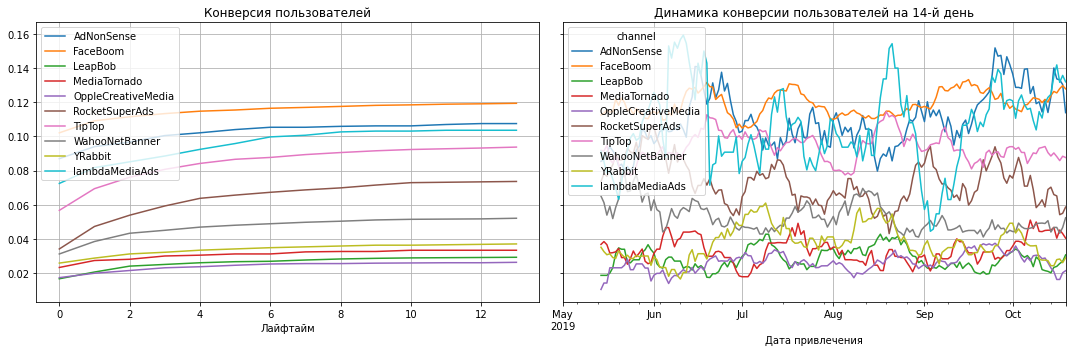

In [37]:
dimensions = ['channel']
# смотрим конверсию с разбивкой по каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

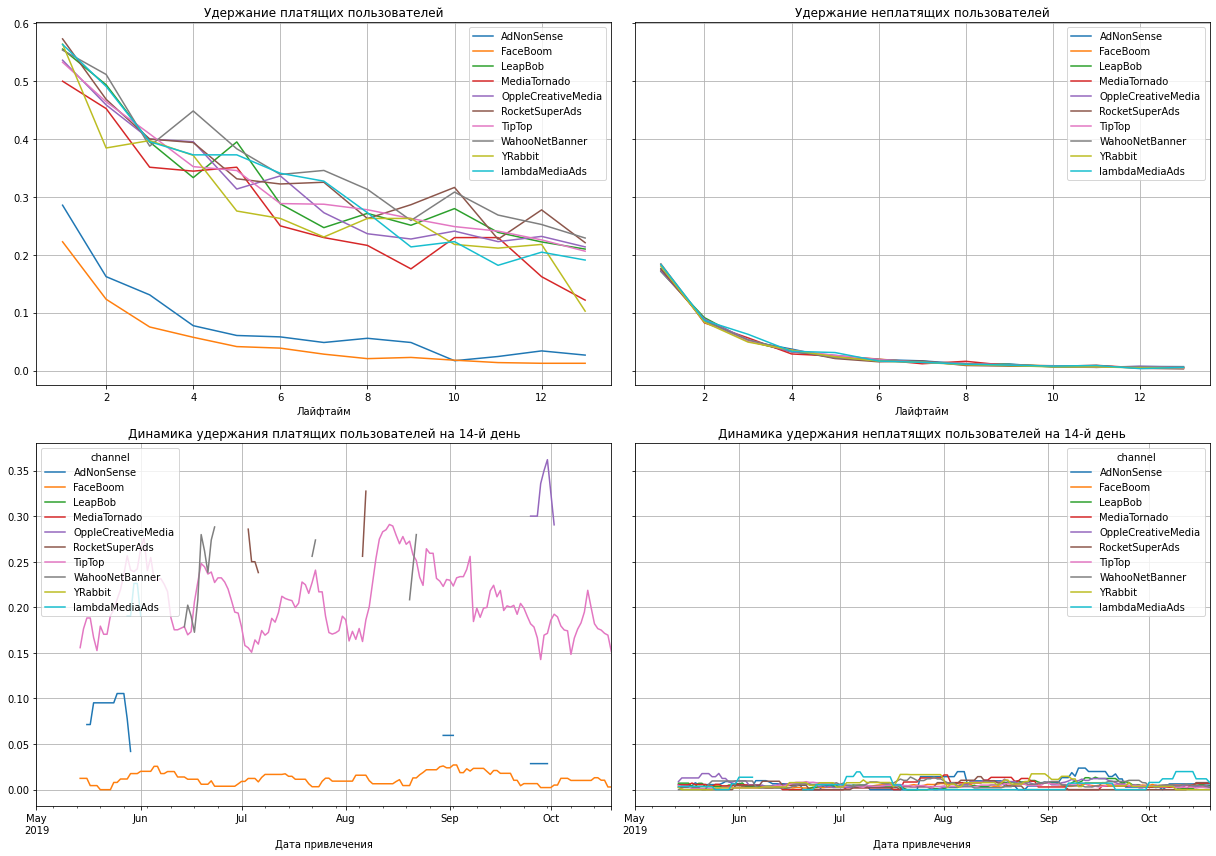

In [38]:

# смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Вывод** Платящие пользователи пришедшие с FaceBoom и AdNonSense стабильно плохо удерживаются. Конверсия, которая на старте была около 30%, стремится к нулю. Возможно, неправильно подобран таргет такой рекламы.

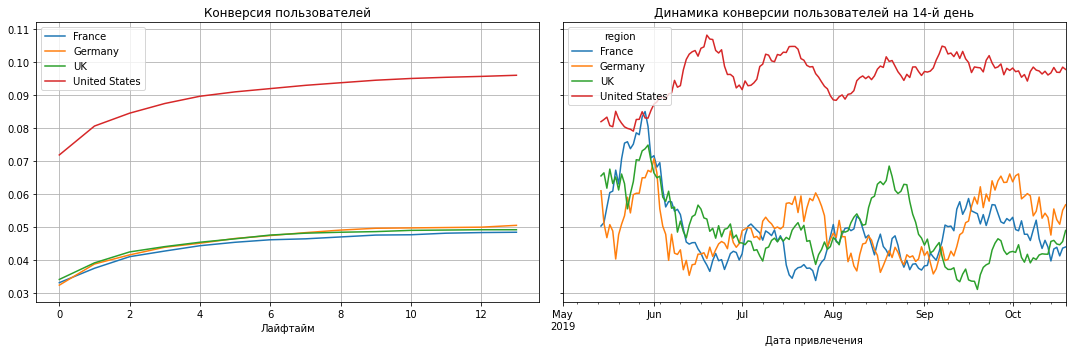

In [39]:
dimensions = ['region']
# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

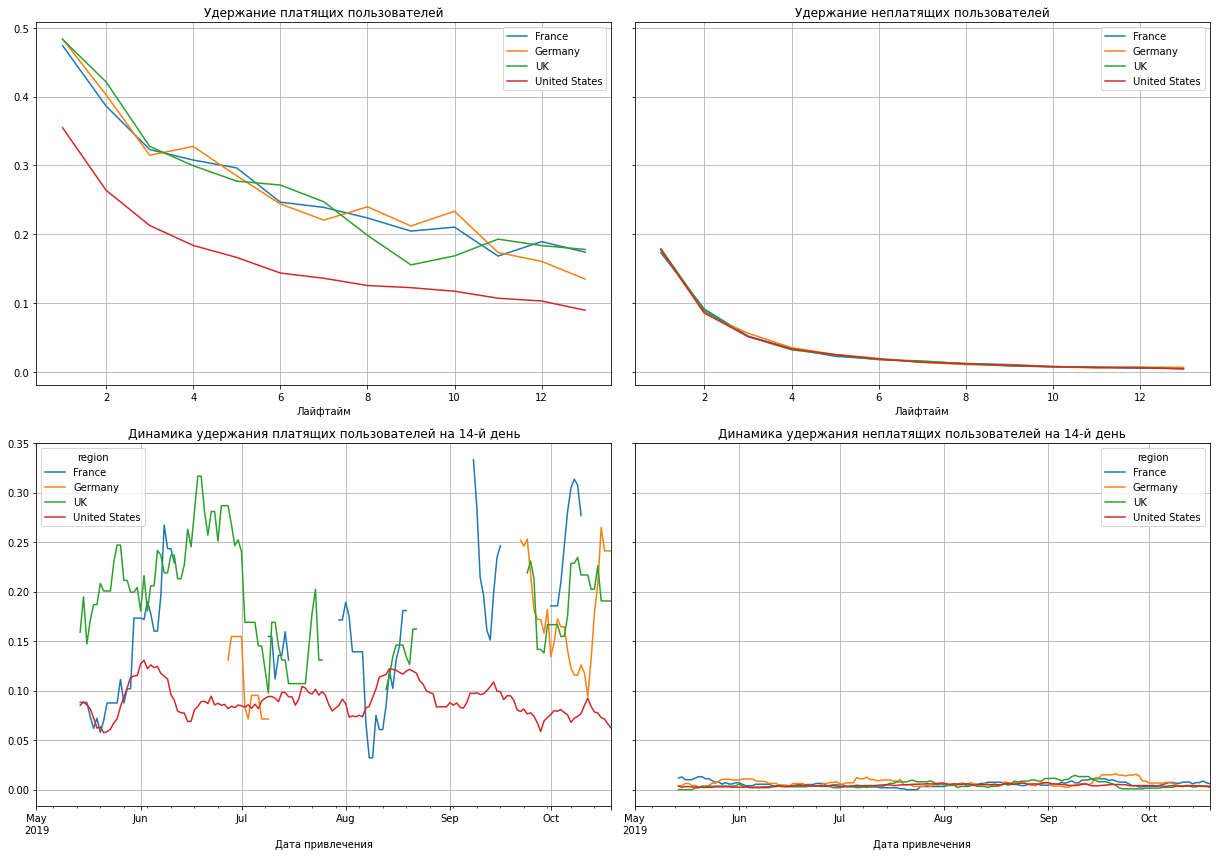

In [40]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод** У пользователей из Америки очень высокая конверси, в динамике стабильна. Однако удержание пользователей колеблется около 10%, что на 10-15% хуже, чем у остальных стран.

CAC пользователей из Америки, а также пользователей устройств iPhone, Mac растёт. Так же растёт CAC пользователя с канала TipTop. Проверим, есть ли здесь связь.

In [41]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000


In [42]:
profiles.query('channel=="TipTop"')['region'].unique() #найдем страныЮ в которых привлекаются пользователи из TipTop

array(['United States'], dtype=object)

Получается, все пользователи, привлеченные из канала TipTop - американцы. В канал TipTop вкладывается больше всего денег, расход велик, а вот удержание американских платящих пользователей хоть и стабильно, но держится на 10%, это недостаточно для окупаемости канала.

In [43]:
USA=profiles.query('region=="United States"').pivot_table(index='device', values='acquisition_cost',aggfunc='count').rename(columns={'acquisition_cost': 'number'}).reset_index()
USA['ratio'] = USA['number']/profiles.query('region=="United States"').shape[0]*100
USA

,device,number,ratio
0,Android,12436,20.113539
1,Mac,15424,24.946223
2,PC,6421,10.385094
3,iPhone,27548,44.555144


Так же мы видим, что 70% пользователей из Америки предпочитают Apple, поэтому мы видим самый высокий CAC по этим устройствам.

## Выводы
    - Эффективность привлечения пользователей не связана с устройством, значит, проблема не в технической ошибке приложения.
    - У канала привлечения TipTop очень большие маркетинговые расходы, а удержание стбильное, но недостаточное для окупаемости
    - У пользователей, пришедших с FaceBoom самый низкий порог удержания Заказывать рекламу там не эффективно.